In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.sparse as sps
import scipy.optimize as optimization
import seaborn as sns

from numba import njit

#%matplotlib inline
%matplotlib widget

In [2]:
@njit()
def diagonalization(Hmat):
  val, vec = np.linalg.eigh(Hmat)
  return val, vec

In [130]:
class Hamiltonian():
  """In short words this class is an object that each method will be a charectristic of the Hamiltonian."""
  def __init__(self, h0, length, Jcom, kappa, PBC, Jres = 1.):
    """
    This will set all the parameters, is also possible to define a not constant J. 
    If the length of Js is not aas large as the system size will fill the other values of J with the Jres value (default is 1.)
    """
    self.h = h0
    self.L = length
    self.PBC = PBC
    self.k = kappa
    if type(Jcom) == float or type(Jcom) == int :
      self.J = np.ones(self.L)*Jcom
    else:
      self.J = np.concatenate((Jcom,np.ones(self.L-Jcom.shape[0])*Jres))

  def __zero_subspace(self,eigsystem, eps=10**(-4)):
    size = eigsystem[0].shape[0] #this returns number of eigenvalues
    zeroindex = [int(size/2)-1,int(size/2)]
    vectors = eigsystem[1].T
    zeroeigenv=[vectors[i] for i in zeroindex]

    if(len(zeroeigenv))!=2:
        print("Alert!, there is no double degeneracy:"+str(len(zeroeigenv)))
        return
    a,b = np.zeros(size), np.zeros(size)

    for i in range(2):
        a += zeroeigenv[i] + np.concatenate((zeroeigenv[i][int(size/2):],zeroeigenv[i][:int(size/2)]))
        b += (-1)**(i)*np.concatenate((zeroeigenv[i][int(size/2):],zeroeigenv[i][:int(size/2)])) + (-1)**(i+1)*zeroeigenv[i]

    a = a/np.linalg.norm(a)
    b = b/np.linalg.norm(b)
    #print("Zero indexes",zeroindex,"a,b",a,b)

    vectors[zeroindex[0]] = (a+b)/np.sqrt(2)
    vectors[zeroindex[1]] = (a-b)/np.sqrt(2)
    return vectors
 
  def matrix(self):
    """One has to be carefull in this part because if PBC is true then this return a lambda function object.matrix()(p) where
    for each p one obtains the parity, but in PBC False this return only one matrix"""
    TL = sps.csr_matrix(np.array([[1,0],[0,0]]))
    TR = sps.csr_matrix(np.array([[0,1],[0,0]]))
    BL = sps.csr_matrix(np.array([[0,0],[1,0]]))
    BR = sps.csr_matrix(np.array([[0,0],[0,1]]))

    A = sps.dok_matrix((self.L,self.L),dtype=np.float32)
    A.setdiag(self.h)
    A.setdiag(-self.J/2, k = 1)
    A.setdiag(-self.J/2, k = -1)

    B = sps.dok_matrix((self.L,self.L),dtype=np.float32)
    B.setdiag(-self.k*self.J/2, k = 1)
    B.setdiag(self.k*self.J/2, k = -1)

    if self.PBC:
      H = np.zeros((2, 2*self.L, 2*self.L))
      for p in range(2):
          A.setdiag(((-1)**p)*self.J/2, k=self.L-1)
          A.setdiag(((-1)**p)*self.J/2, k=1-self.L)
          B.setdiag(-((-1)**p)*self.k*self.J/2, k=self.L-1)
          B.setdiag(((-1)**p)*self.k*self.J/2, k=1-self.L)
          H[p] = (sps.kron(TL, A) + sps.kron(TR, B) + sps.kron(BL, -B) + sps.kron(BR, -A)).toarray()
      Hmat = lambda x: H[x]
    else:
      Hmat = sps.kron(TL, A) + sps.kron(TR, B) + sps.kron(BL, -B) + sps.kron(BR, -A)
      Hmat = Hmat.toarray()
    return Hmat
  
  def eigensystem(self):
    """
    Generates the eigensytem for the parameters defined. 
    It returns a tuple where first element are the eigenvalues and second element are the eigenvectors, 
    if PBC flag is true then returns 4*L eigenvalues and eigenvectors, if not only returns 2*L eigenvalues and eigenvectors.
    """
    H = self.matrix()
    if not self.PBC:
      eigsystem = diagonalization(H)
      vectors = self.__zero_subspace(eigsystem)
      return eigsystem[0], vectors
    else:
      eigsystem_0 = diagonalization(H(0))
      eigsystem_1 = diagonalization(H(1))
      values = np.concatenate((eigsystem_0[0], eigsystem_1[0]))
      vectors = np.concatenate((eigsystem_0[1].T, eigsystem_1[1].T))
      return values, vectors
    
  def U_matrix(self, vectors=None):
    """if PBC is true then this return a lambda function object.matrix()(p) where
    for each p one obtains the parity, but in PBC False this return only one matrix"""
    if vectors == None:
      vectors = self.eigensystem()[1]
    G_gam = sps.kron(sps.csr_matrix(np.array([[1,0],[0,0]])),np.eye(self.L)).toarray()
    if self.PBC:
      sector = np.array([vectors[:2*self.L],vectors[2*self.L:]])
      U = lambda x : np.concatenate((sector[x][self.L:],np.concatenate((sector[x][self.L:].T[self.L:], sector[x][self.L:].T[:self.L])).T)).conj().T
    else:
      U = np.concatenate((vectors[self.L:],np.concatenate((vectors[self.L:].T[self.L:], vectors[self.L:].T[:self.L])).T)).conj().T
    return U
    
  def greenFunc(self, vectors=None):
    """if PBC is true then this return a lambda function object.matrix()(p) where
    for each p one obtains the parity, but in PBC False this return only one matrix"""
    if vectors == None:
      vectors = self.eigensystem()[1]
    G_gam = sps.kron(sps.csr_matrix(np.array([[1,0],[0,0]])),np.eye(self.L)).toarray()
    if self.PBC:
      sector = np.array([vectors[:2*self.L],vectors[2*self.L:]])
      Udag = lambda x : np.concatenate((sector[x][self.L:],np.concatenate((sector[x][self.L:].T[self.L:], sector[x][self.L:].T[:self.L])).T))
      G = lambda x: Udag(x).T@G_gam@Udag(x)
    else:
      Udag = np.concatenate((vectors[self.L:],np.concatenate((vectors[self.L:].T[self.L:], vectors[self.L:].T[:self.L])).T))
      G = Udag.T@G_gam@Udag
    return G


Text(0, 0.5, '$E$')

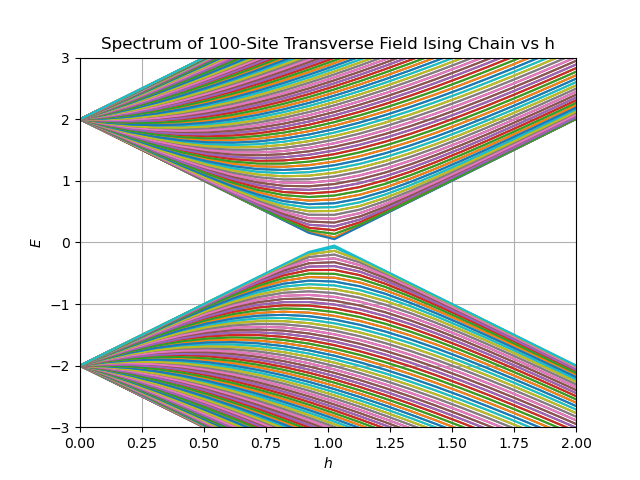

In [72]:
L=100
J=1.
kappa=1.
Hs = np.r_[0:4:40j]
ens = []
eigv = np.zeros((len(Hs), 2*L , 1), dtype=float)


for (i,h) in enumerate(Hs):
  H = Hamiltonian(h, L, J, kappa, PBC=True)
  val = H.eigensystem()
  ens.append(val[0]*2)

  
  
# We plot the spectrum.
# Zoom as you wish, if your %matplotlib notebook magic is properly working (not in Colab, apparently)
plt.figure()
plt.plot(Hs, ens, '-')
plt.title(r'Spectrum of '+str(L)+r'-Site Transverse Field Ising Chain vs h')
plt.grid()
plt.xlim((0,2))
plt.ylim((-3,3))
plt.xlabel(r'$h$')
plt.ylabel(r'$E$')


In [131]:
H = Hamiltonian(0.25, 40, 1., 1., PBC=False)

# plt.figure()
# plt.imshow(H.matrix(),interpolation='none',cmap='bwr')
# plt.colorbar()
# plt.show()

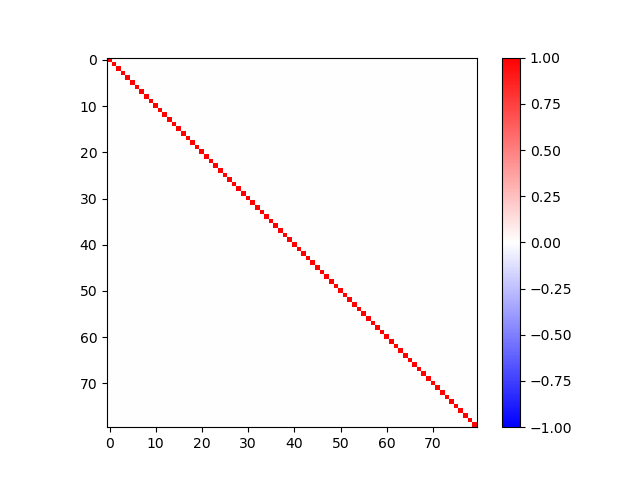

In [133]:
U = H.U_matrix()
plt.figure()
plt.imshow(U.conj().T@U,interpolation='none',cmap='bwr', norm=matplotlib.colors.CenteredNorm())
plt.colorbar()
plt.show()

In [125]:
help(Hamiltonian)

Help on class Hamiltonian in module __main__:

class Hamiltonian(builtins.object)
 |  Hamiltonian(h0, length, Jcom, kappa, PBC, Jres=1.0)
 |  
 |  In short words this class is an object that each method will be a charectristic of the Hamiltonian.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, h0, length, Jcom, kappa, PBC, Jres=1.0)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  eigensystem(self)
 |  
 |  greenFunc(self, vectors=None)
 |      if PBC is true then this return a lambda function object.matrix()(p) where
 |      for each p one obtains the parity, but in PBC False this return only one matrix
 |  
 |  matrix(self)
 |      One has to be carefull in this part because if PBC is true then this return a lambda function object.matrix()(p) where
 |      for each p one obtains the parity, but in PBC False this return only one matrix
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here

In [69]:
y[1]

array([[2, 4],
       [6, 8]])

In [54]:
x.append([2])

In [98]:
b = lambda c: c+1
d = lambda f: b(f)
d(3)

4